In [1]:
from pygenomeviz import GenomeViz
import Bio.SeqIO as SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pysam
import re
import os
import subprocess
import seaborn as sns
import sys
from PIL import Image
from tqdm import tqdm
sys.path.append('../')
from transcriptomics import * 
from plotting import * 
import warnings 
from concurrent.futures import ProcessPoolExecutor
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', None)

# Load genome
genome_fasta_path = '../genome/Obir.assembly.v5.4.fasta'
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_fasta_path, "fasta"))

# Load transcriptome
tr = load_transcriptome_object("../transcriptome/biroi_transcriptome.pkl")

# Load or_db
or_db = pd.read_excel('../ORs/OR List.xlsx') 

black_plotting()

Initializing transcriptomics package
Initializing plotting package


In [ ]:
#or_db.loc[or_db.gene_name.isin(['Or5-9E198', 'Or5-9E200', 'Or5-9E201']), 'tandem_array'] = 35

## Convert coverage files to h5 files, split by chromosome 
- Only need to do this once (done on Jan 10 2025)

In [ ]:
"""# Get chromsizes for genome
chromsizes = {}
for chrom in genome_seq:
    if "Chr" in chrom:
        chromsizes[chrom] = len(genome_seq[chrom].seq)

input_directory = "../JL20240124_FemaleRNAseq_first_of_pair_strand_coverage"  # Directory containing ~20 input files
output_directory = "../JL20240124_FemaleRNAseq_first_of_pair_strand_coverage_chrom_h5"  # Directory to store split files

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Remove any existing files in the output directory
for file_name in os.listdir(output_directory):
    os.remove(os.path.join(output_directory, file_name))

# Iterate over files in the input directory
for file_name in os.listdir(input_directory):

    # Initialize data storage for each chromosome
    chromosome_data = {chrom: [] for chrom in chromsizes}

    # Process the file
    input_path = os.path.join(input_directory, file_name)
    print(f"Processing {input_path}")
    with open(input_path, 'r') as infile:
        for line in infile:
            columns = line.strip().split('\t')
            
            chromosome, bp_index, coverage = columns
            if chromosome in chromosome_data:
                chromosome_data[chromosome].append(int(coverage))

    # Validate size 
    for chrom, expected_size in chromsizes.items():
        coverage_list = chromosome_data[chrom]
        
        # Ensure the correct size
        if len(coverage_list) != expected_size:
            raise ValueError(f"Chromosome {chrom} has incorrect size: "
                                f"expected {expected_size}, got {len(coverage_list)}")
        
    # Write to output file
    base_name = os.path.splitext(file_name)[0]
    output_file = os.path.join(output_directory, f"{base_name}.h5")
    with h5py.File(output_file, 'w') as f:
        for chrom, coverage in chromosome_data.items():
            f.create_dataset(chrom, data=np.array(coverage, dtype=int))
    print(f"Wrote {output_file}")
"""

Processing ../JL20240124_FemaleRNAseq_first_of_pair_strand_coverage/F2_Aligned.sortedByCoord.out_reverse_strand_coverage.txt
Wrote ../JL20240124_FemaleRNAseq_first_of_pair_strand_coverage_chrom_h5/F2_Aligned.sortedByCoord.out_reverse_strand_coverage.h5
Processing ../JL20240124_FemaleRNAseq_first_of_pair_strand_coverage/F2_Aligned.sortedByCoord.out_forward_strand_coverage.txt
Wrote ../JL20240124_FemaleRNAseq_first_of_pair_strand_coverage_chrom_h5/F2_Aligned.sortedByCoord.out_forward_strand_coverage.h5
Processing ../JL20240124_FemaleRNAseq_first_of_pair_strand_coverage/F1_Aligned.sortedByCoord.out_forward_strand_coverage.txt
Wrote ../JL20240124_FemaleRNAseq_first_of_pair_strand_coverage_chrom_h5/F1_Aligned.sortedByCoord.out_forward_strand_coverage.h5
Processing ../JL20240124_FemaleRNAseq_first_of_pair_strand_coverage/F1_Aligned.sortedByCoord.out_reverse_strand_coverage.txt
Wrote ../JL20240124_FemaleRNAseq_first_of_pair_strand_coverage_chrom_h5/F1_Aligned.sortedByCoord.out_reverse_strand_

## Assemble a list of genes 
- 100bp - 10kb

In [ ]:
min_cds_length = 100 
max_gene_length = 10000 

In [ ]:
genome_db = pd.DataFrame(columns=['gene_name', 'chromosome', 'start', 'end', 'strand', 'cds_length'])

for gene_name in tr.genes.keys(): 
    gene = tr.get_gene(gene_name)
    if len(gene.transcripts) == 0: 
        continue
    min_start = min([transcript.get_bounds()[0] for transcript in gene.transcripts])
    max_end = max([transcript.get_bounds()[1] for transcript in gene.transcripts])
    length = max_end - min_start
    cds_length = gene.get_transcript_longest_cds().cds_length
    if length >= max_gene_length or cds_length <= min_cds_length:
        continue 
    genome_db = genome_db._append({'gene_name': gene_name, 'chromosome': gene.chromosome, 'start': min_start, 'end': max_end, 'strand': gene.strand, 'cds_length': cds_length}, ignore_index=True)

genome_db

,gene_name,chromosome,start,end,strand,cds_length
0,CSP10.2,Chr13,1251897,1257450,+,354
1,Csp1,Chr10,2992852,2994140,-,375
2,Csp10,Chr13,1227032,1231037,+,354
3,Csp11,Chr10,8970673,8972214,+,441
4,Csp12,Chr5,13419564,13420947,+,363
...,...,...,...,...,...,...
9259,Or5-W1,Chr1,17242051,17244336,-,1341
9260,Or5-X1,Chr1,18406478,18409631,-,1110
9261,Or5-XA1,Chr3,802044,806553,+,1431
9262,Or5-Y1,Chr2,3732298,3735172,+,1161


In [ ]:
# Sort genome_db first by chromosome then by end position 
genome_db = genome_db.sort_values(by=['chromosome', 'end'])
genome_db = genome_db.reset_index(drop=True)
genome_db

,gene_name,chromosome,start,end,strand,cds_length
0,LOC105288151,Chr1,1070,7288,+,2613
1,LOC105288134,Chr1,45264,47168,+,648
2,LOC105288138,Chr1,134260,142204,-,2190
3,LOC113562194,Chr1,271139,273181,-,1554
4,LOC105288142,Chr1,273665,275760,+,1110
...,...,...,...,...,...,...
9259,LOC105279494,Chr9,15580792,15586348,-,2451
9260,LOC105279490,Chr9,15587878,15591696,+,1572
9261,LOC105279491,Chr9,15591805,15596813,+,2802
9262,LOC105279492,Chr9,15596831,15598680,-,894


In [ ]:
# Find adjacent genes: same chromosome, same strand, distance > 5bp 
min_distance = 5 # bp 
adjacent_gene_db = pd.DataFrame(columns=['gene_1', 'gene_2', 'chromosome', 'start_1', 'end_1', 'start_2', 'end_2', 'strand_1', 'strand_2', 'distance'])
for i in range(len(genome_db)-1): 
    gene_1 = genome_db.iloc[i]
    gene_2 = genome_db.iloc[i+1]
    if gene_1['chromosome'] == gene_2['chromosome'] and gene_1['strand'] == gene_2['strand'] and gene_1['end'] < gene_2['start']: 
        distance = gene_2['start'] - gene_1['end']
        if distance >= min_distance: 
            adjacent_gene_db = adjacent_gene_db._append({'gene_1': gene_1['gene_name'], 'gene_2': gene_2['gene_name'], 'chromosome': gene_1['chromosome'], 'start_1': gene_1['start'], 'end_1': gene_1['end'], 'start_2': gene_2['start'], 'end_2': gene_2['end'], 'strand_1': gene_1['strand'], 'strand_2': gene_2['strand'], 'distance': distance}, ignore_index=True)

adjacent_gene_db

,gene_1,gene_2,chromosome,start_1,end_1,start_2,end_2,strand_1,strand_2,distance
0,LOC105288151,LOC105288134,Chr1,1070,7288,45264,47168,+,+,37976
1,LOC105288138,LOC113562194,Chr1,134260,142204,271139,273181,-,-,128935
2,LOC113563206,LOC113562127,Chr1,404381,409670,534042,537304,-,-,124372
3,LOC113562288,LOC113562287,Chr1,541732,542562,545053,551825,+,+,2491
4,LOC113562287,LOC113562164,Chr1,545053,551825,609439,611633,+,+,57614
...,...,...,...,...,...,...,...,...,...,...
4156,LOC105279504,LOC105279501,Chr9,15543493,15547966,15548459,15550572,+,+,493
4157,LOC105279502,LOC113562513,Chr9,15550499,15553325,15553362,15554812,-,-,37
4158,LOC105279498,LOC105279494,Chr9,15571888,15579051,15580792,15586348,-,-,1741
4159,LOC105279490,LOC105279491,Chr9,15587878,15591696,15591805,15596813,+,+,109


In [ ]:
# Add location of the intergenic region to adjacent_gene_db
adjacent_gene_db['location'] = adjacent_gene_db.apply(lambda x: f"{x["chromosome"]}:{x["end_1"]}-{x["start_2"]}", axis=1)
# Make a column that is true if both genes are in or_db 
adjacent_gene_db['both_ORs'] = adjacent_gene_db.apply(lambda x: x['gene_1'] in or_db['gene_name'].values and x['gene_2'] in or_db['gene_name'].values, axis=1)
# Add a column for TA (tandem array) for each pair in adjacent_gene_db where both_ORs is true using or_db
adjacent_gene_db['TA'] = adjacent_gene_db.apply(lambda x: or_db[or_db['gene_name'] == x['gene_1']]['tandem_array'].values[0] if x['both_ORs'] else None, axis=1)
adjacent_gene_db['TA_size'] = adjacent_gene_db.apply(lambda x: len(or_db[or_db['tandem_array'] == x['TA']]) if x['both_ORs'] else None, axis=1)
adjacent_gene_db['nine-exon'] = adjacent_gene_db.apply(lambda x: ("9E" in x['gene_1'] and "9E" in x['gene_2']) if x["both_ORs"] else "non-OR", axis=1)
adjacent_gene_db['nine-exon'] = adjacent_gene_db['nine-exon'].astype(str)
adjacent_gene_db[adjacent_gene_db['both_ORs'] == True]

,gene_1,gene_2,chromosome,start_1,end_1,start_2,end_2,strand_1,strand_2,distance,location,both_ORs,TA,TA_size,nine-exon
142,Or5-R2,Or5-Q1,Chr1,6504395,6510987,6511625,6514800,-,-,638,Chr1:6510987-6511625,True,70.0,2.0,False
323,Or5-9E4,Or5-9E5,Chr1,17883604,17887432,17889077,17892268,-,-,1645,Chr1:17887432-17889077,True,79.0,12.0,True
324,Or5-9E5,Or5-9Efrag1,Chr1,17889077,17892268,17894999,17896696,-,-,2731,Chr1:17892268-17894999,True,79.0,12.0,True
325,Or5-9Efrag1,Or5-9E6,Chr1,17894999,17896696,17897629,17901737,-,-,933,Chr1:17896696-17897629,True,79.0,12.0,True
326,Or5-9E6,Or5-9E7,Chr1,17897629,17901737,17903405,17907766,-,-,1668,Chr1:17901737-17903405,True,79.0,12.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4122,Or5-E13,Or5-E14,Chr9,14875775,14879371,14879478,14882434,-,-,107,Chr9:14879371-14879478,True,86.0,16.0,False
4125,Or5-E15,Or5-E16,Chr9,14886183,14888412,14892004,14895862,-,-,3592,Chr9:14888412-14892004,True,86.0,16.0,False
4126,Or5-E16,Or5-E17,Chr9,14892004,14895862,14899946,14901917,-,-,4084,Chr9:14895862-14899946,True,86.0,16.0,False
4127,Or5-E17,Or5-E18,Chr9,14899946,14901917,14902605,14904727,-,-,688,Chr9:14901917-14902605,True,86.0,16.0,False


## Remove any regions that are overlapping with existing features 
For instance if a gene is within the intron of another gene 

In [ ]:
all_genes = [tr.get_gene(gene) for gene in tr.genes.keys() if len(tr.get_gene(gene).transcripts) > 0]
all_chr = list(set([gene.chromosome for gene in all_genes]))

14

In [ ]:
chr_features = {} 
for chr_name in all_chr: 
    chr_features[chr_name] = []
    for gene in all_genes: 
        if gene.chromosome == chr_name: 
            for transcript in gene.transcripts: 
                for exon in transcript.exons: 
                    chr_features[chr_name].append(exon)
                for intron in transcript.introns: 
                    chr_features[chr_name].append(intron)

In [ ]:
def overlapping(chr1, start1, end1, chr2, start2, end2, min_overlap=0): 
    """ Returns true if the two regions overlap by at least min_overlap bases """
    # Check if the two regions are on the same chromosome
    if chr1 != chr2: 
        return False
    # Check if the two regions overlap by at least min_overlap bases
    overlap = max(0, min(end1, end2) - max(start1, start2))
    return overlap >= min_overlap

In [ ]:
adjacent_gene_db['overlapping_feature'] = False
for chr in tqdm(all_chr, desc='Chromosome'): 
    chr_adjacent_genes = adjacent_gene_db[adjacent_gene_db['chromosome'] == chr]
    for i, row in chr_adjacent_genes.iterrows(): 
        for feature in chr_features[chr]: 
            if overlapping(row['chromosome'], row['end_1'], row['start_2'], feature.chromosome, feature.position[0], feature.position[1], min_overlap=5): 
                adjacent_gene_db.at[i, 'overlapping_feature'] = True 
                # Break the current loop and move on to the next gene
                break

Chromosome: 100%|██████████| 14/14 [15:17<00:00, 65.53s/it]


In [ ]:
# Get the number of adjacent genes that overlap with a feature
adjacent_gene_db[adjacent_gene_db['overlapping_feature'] == True].shape[0]

NameError: name 'adjacent_gene_db' is not defined

In [ ]:
# Remove the adjacent genes that overlap with a feature
adjacent_gene_db_nonoverlapping = adjacent_gene_db[adjacent_gene_db['overlapping_feature'] == False].copy() 

In [ ]:
# Save the non-overlapping adjacent genes to a file
adjacent_gene_db_nonoverlapping.to_csv('../results/adjacent_gene_db_nonoverlapping.csv', index=False)

In [ ]:
# Load the non-overlapping adjacent genes from a file
adjacent_gene_db_nonoverlapping = pd.read_csv('../results/adjacent_gene_db_nonoverlapping.csv')
adjacent_gene_db_nonoverlapping.shape

(2458, 16)

## Take a random sample of the non-OR genes

In [3]:
# For adjacent_gene_db, take all OR intergenic regions and an equal number of non-OR regions 
ORs = adjacent_gene_db_nonoverlapping[adjacent_gene_db_nonoverlapping['both_ORs'] == True].copy() 
non_ORs = adjacent_gene_db_nonoverlapping[adjacent_gene_db_nonoverlapping['both_ORs'] == False].copy() 
non_ORs = non_ORs.sample(n=ORs.shape[0], random_state=0)
adjacent_gene_db_subset = pd.concat([ORs, non_ORs])
adjacent_gene_db_subset = adjacent_gene_db_subset.reset_index(drop=True)
adjacent_gene_db_subset

,gene_1,gene_2,chromosome,start_1,end_1,start_2,end_2,strand_1,strand_2,distance,location,both_ORs,TA,TA_size,nine-exon,overlapping_feature
0,Or5-R2,Or5-Q1,Chr1,6504395,6510987,6511625,6514800,-,-,638,Chr1:6510987-6511625,True,70.0,2.0,False,False
1,Or5-9E4,Or5-9E5,Chr1,17883604,17887432,17889077,17892268,-,-,1645,Chr1:17887432-17889077,True,79.0,12.0,True,False
2,Or5-9E5,Or5-9Efrag1,Chr1,17889077,17892268,17894999,17896696,-,-,2731,Chr1:17892268-17894999,True,79.0,12.0,True,False
3,Or5-9Efrag1,Or5-9E6,Chr1,17894999,17896696,17897629,17901737,-,-,933,Chr1:17896696-17897629,True,79.0,12.0,True,False
4,Or5-H1,Or5-X1,Chr1,18401037,18404290,18406478,18409631,-,-,2188,Chr1:18404290-18406478,True,80.0,4.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,LOC105275870,LOC105275865,Chr11,5830833,5834811,5837256,5841149,+,+,2445,Chr11:5834811-5837256,False,NaN,NaN,non-OR,False
436,LOC105287031,LOC105287033,Chr2,66434,69425,70801,72648,+,+,1376,Chr2:69425-70801,False,NaN,NaN,non-OR,False
437,LOC105288224,LOC105288223,Chr11,2570316,2578738,2581639,2585046,+,+,2901,Chr11:2578738-2581639,False,NaN,NaN,non-OR,False
438,LOC105284036,LOC109611283,Chr1,13169561,13172814,13173343,13174793,+,+,529,Chr1:13172814-13173343,False,NaN,NaN,non-OR,False


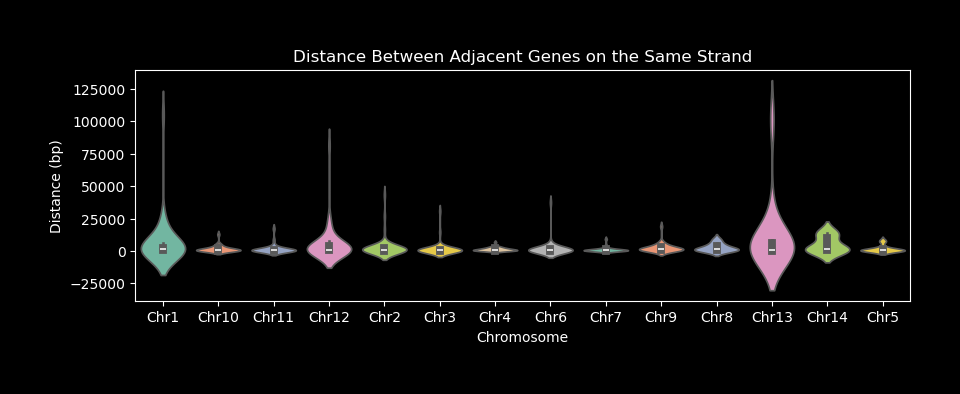

In [4]:
# Plot the average distance for for adjacent genes on the same strand, split by chromosome
fig, ax = plt.subplots(figsize=(10, 3))
sns.violinplot(x='chromosome', y='distance', data=adjacent_gene_db_subset, ax=ax, palette='Set2')
plt.title('Distance Between Adjacent Genes on the Same Strand')
plt.xlabel('Chromosome')
plt.ylabel('Distance (bp)')
plt.show()

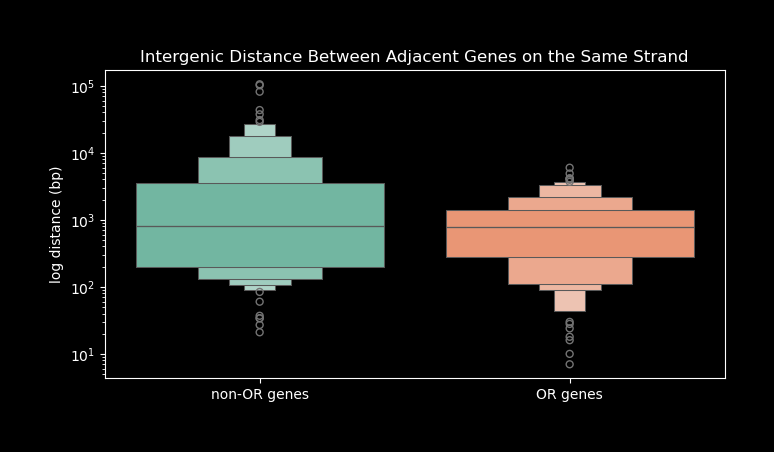

In [5]:
# Plot the average distance for for adjacent genes on the same strand, split by both_ORs, on a log y axis 
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxenplot(x='both_ORs', y='distance', data=adjacent_gene_db_subset, ax=ax, palette='Set2')
plt.title('Intergenic Distance Between Adjacent Genes on the Same Strand')
plt.xlabel('')
plt.ylabel('log distance (bp)')
plt.yscale('log')
plt.xticks([0, 1], ['non-OR genes', 'OR genes'])
plt.show()

In [6]:
# Check whether the distance between adjacent genes on the same strand is significantly different between ORs and non-ORs, using ranksum 
from scipy.stats import ranksums
OR_distances = adjacent_gene_db_subset[adjacent_gene_db_subset['both_ORs'] == True]['distance']
non_OR_distances = adjacent_gene_db_subset[adjacent_gene_db_subset['both_ORs'] == False]['distance']
ranksums(OR_distances, non_OR_distances)

RanksumsResult(statistic=-2.0769613579938486, pvalue=0.0378051258614866)

## Plot coverage of a tandem array 

In [7]:
def get_coverage(sample, orientation, chrom, start, end): 
    base_path = '../JL20240124_FemaleRNAseq_first_of_pair_strand_coverage_chrom_h5'
    # Check that orientation is fwd or rev 
    assert orientation in ['fwd', 'rev'], "Orientation must be 'fwd' or 'rev'"
    # Replace fwd and rev with forward and reverse 
    orientation = 'forward' if orientation == 'fwd' else 'reverse'
    # Get the file path
    file_path = f"{base_path}/{sample}_Aligned.sortedByCoord.out_{orientation}_strand_coverage.h5"

    # Reading data
    with h5py.File(file_path, 'r') as f:
        chr_data = f[chrom][:]
    
    # Checks 
    assert 0 <= start < len(chr_data), "Start index is out of range"
    assert 0 < end <= len(chr_data), "End index is out of range"
    assert start < end, "Start must be less than end"

    # Return the coverage values for the specified range
    return chr_data[start:end]


T17: Chr10:12693839-13150935


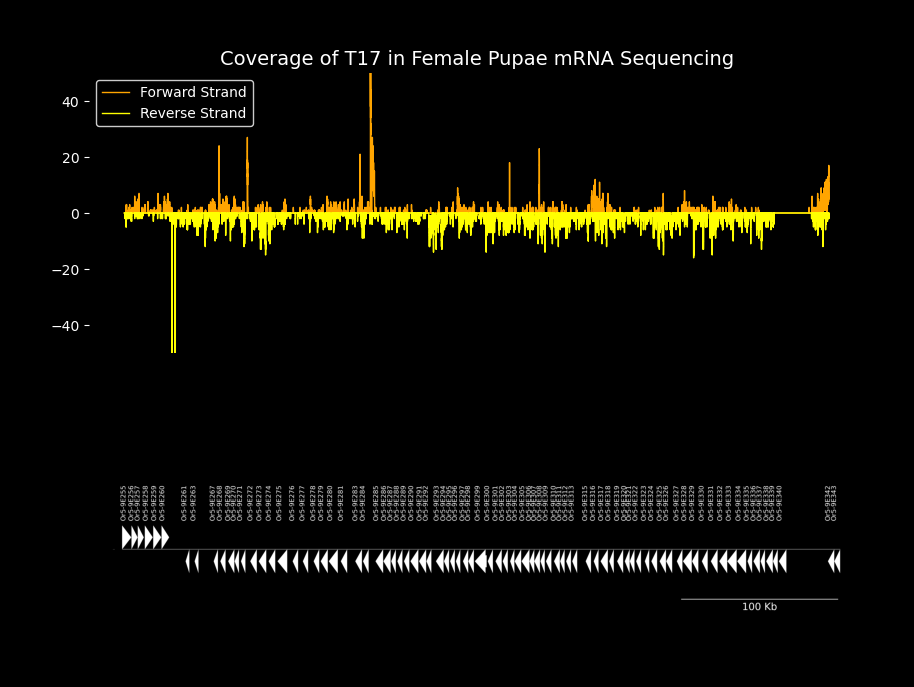

In [8]:
# Tandem Array Info
TA = 17
ta_genes = or_db[or_db['tandem_array'] == TA]['gene_name'].values
ta_chr = tr.get_gene(ta_genes[0]).chromosome

# Get gene bounds
ta_gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in ta_genes]
ta_start, ta_end = min([bounds[0] for bounds in ta_gene_bounds]), max([bounds[1] for bounds in ta_gene_bounds])
print(f"T{TA}: {ta_chr}:{ta_start}-{ta_end}")

# Specify Tisues 
tissues = ['F1']


fig, axs = plt.subplots(len(tissues)+1, 1, figsize=(10, 8))
for i, tissue in enumerate(tissues):
    # Get Coverage
    fwd_coverage = get_coverage(tissue, 'fwd', ta_chr, ta_start, ta_end)
    rev_coverage = get_coverage(tissue, 'rev', ta_chr, ta_start, ta_end)

    # Plot Coverage
    ylim = max(max(fwd_coverage), max(rev_coverage)) + 10
    axs[i].plot(fwd_coverage, color='orange', label='Forward Strand', linewidth=1)
    axs[i].plot(-np.array(rev_coverage), color='yellow', label='Reverse Strand', linewidth=1)
    axs[i].set_title(f"Coverage of T{TA} in Female Pupae mRNA Sequencing", fontsize=14)
    axs[i].set_ylabel('')
    axs[i].set_ylim(-50, 50)
    axs[i].set_xticks([])
    #axs[i].set_yticks([])
    axs[0].legend(loc='upper left')
    for spine in axs[i].spines.values():
        spine.set_visible(False)

# Gene Annotations using GenomeViz
gv = GenomeViz(track_align_type="center", theme="dark")
gv.set_scale_bar(ymargin=0.5)

# Create Feature Track
track = gv.add_feature_track(ta_chr, (int(ta_start), int(ta_end)), labelsize=0)

# Add Gene Models
for gene_name in ta_genes:
    gene = tr.get_gene(gene_name)
    transcript = gene.get_transcript_longest_cds()
    bounds = transcript.get_bounds()
    strand = 1 if transcript.strand == '+' else -1
    track.add_feature(
        int(bounds[0]), int(bounds[1]),
        strand,
        plotstyle='arrow',
        fc='white', 
        ec='black', 
        arrow_shaft_ratio=0.5,
        label=gene_name, 
        text_kws={'color': 'white', 'rotation': 90, 'size':10}
    )

# Render GenomeViz as an Image
output_file = "../results/genome_viz.png"
gv.savefig(output_file, dpi=300)

# Display GenomeViz on Second Subplot
img = Image.open(output_file)
axs[len(tissues)].imshow(img)
axs[len(tissues)].axis('off')

# Finalize and Show
plt.show()

## Read in rRNA-Depleted RNAseq Data 
- 16 minutes

In [9]:
def process_tissue(tissue, adjacent_gene_db):
    tissue_db = adjacent_gene_db.copy()
    for i, row in adjacent_gene_db.iterrows():
        chrom = row['chromosome']
        upstream_gene = row['gene_1'] if row['strand_1'] == '+' else row['gene_2']
        upstream_transcript = tr.get_gene(upstream_gene).get_transcript_longest_cds()

        # Process exons
        if len(upstream_transcript.exons) > 0:
            exon_fwd_coverage = np.concatenate([
                get_coverage(tissue, 'fwd', chrom, start, end)
                for start, end in (exon.position for exon in upstream_transcript.exons)
            ], axis=0)
            exon_rev_coverage = np.concatenate([
                get_coverage(tissue, 'rev', chrom, start, end)
                for start, end in (exon.position for exon in upstream_transcript.exons)
            ], axis=0)

            # Save exon coverage
            tissue_db.at[i, f'upstream_exon_fwd_{tissue}'] = exon_fwd_coverage.mean() 
            tissue_db.at[i, f'upstream_exon_rev_{tissue}'] = exon_rev_coverage.mean() 

        # Process introns
        if len(upstream_transcript.introns) > 0: 
            intron_fwd_coverage = np.concatenate([
                get_coverage(tissue, 'fwd', chrom, start, end)
                for start, end in (intron.position for intron in upstream_transcript.introns)
            ], axis=0)
            intron_rev_coverage = np.concatenate([
                get_coverage(tissue, 'rev', chrom, start, end)
                for start, end in (intron.position for intron in upstream_transcript.introns)
            ], axis=0)

            # Save intron coverage
            tissue_db.at[i, f'upstream_intron_fwd_{tissue}'] = intron_fwd_coverage.mean() 
            tissue_db.at[i, f'upstream_intron_rev_{tissue}'] = intron_rev_coverage.mean() 

        # Process intergenic regions
        end_1, start_2 = row['end_1'], row['start_2'] 
        fwd_cov = get_coverage(tissue, 'fwd', chrom, end_1, start_2)
        rev_cov = get_coverage(tissue, 'rev', chrom, end_1, start_2)
        tissue_db.at[i, f'intergenic_fwd_{tissue}'] = fwd_cov.mean()
        tissue_db.at[i, f'intergenic_rev_{tissue}'] = rev_cov.mean()
        tissue_db.at[i, f'intergenic_fwd_prop_{tissue}'] = (fwd_cov > 0).sum() / len(fwd_cov) 
        tissue_db.at[i, f'intergenic_rev_prop_{tissue}'] = (rev_cov > 0).sum() / len(rev_cov) 

    return tissue_db

# Main processing function
def process_all_tissues(tissues, adjacent_gene_db):
    results = []
    with ProcessPoolExecutor() as executor:
        futures = {executor.submit(process_tissue, tissue, adjacent_gene_db): tissue for tissue in tissues}
        for future in futures:
            result = future.result()
            if result is not None:
                results.append(result)

    # Merge results back into the main database
    for result in results:
        for col in result.columns:
            if col not in adjacent_gene_db.columns:
                adjacent_gene_db[col] = None  # Add new columns to main DB
        adjacent_gene_db.update(result)


tissues = ['F1']
process_all_tissues(tissues, adjacent_gene_db_subset)

In [10]:
# Save results 
adjacent_gene_db_subset.to_csv('../results/adjacent_gene_db_subset_coverage_female_20240116.csv', index=False)

In [11]:
adjacent_gene_db_subset = pd.read_csv('../results/adjacent_gene_db_subset_coverage_female_20240116.csv')
adjacent_gene_db_subset.shape

(440, 24)

In [12]:
adjacent_gene_db_subset

,gene_1,gene_2,chromosome,start_1,end_1,start_2,end_2,strand_1,strand_2,distance,location,both_ORs,TA,TA_size,nine-exon,overlapping_feature,upstream_exon_fwd_F1,upstream_exon_rev_F1,upstream_intron_fwd_F1,upstream_intron_rev_F1,intergenic_fwd_F1,intergenic_rev_F1,intergenic_fwd_prop_F1,intergenic_rev_prop_F1
0,Or5-R2,Or5-Q1,Chr1,6504395,6510987,6511625,6514800,-,-,638,Chr1:6510987-6511625,True,70.0,2.0,False,False,0.000000,0.546282,0.000000,0.000000,0.017241,0.000000,0.017241,0.000000
1,Or5-9E4,Or5-9E5,Chr1,17883604,17887432,17889077,17892268,-,-,1645,Chr1:17887432-17889077,True,79.0,12.0,True,False,0.148810,2.389286,0.000000,0.866711,0.151976,0.128267,0.151976,0.128267
2,Or5-9E5,Or5-9Efrag1,Chr1,17889077,17892268,17894999,17896696,-,-,2731,Chr1:17892268-17894999,True,79.0,12.0,True,False,0.000000,0.214961,0.000000,0.000000,0.000000,0.091542,0.000000,0.075064
3,Or5-9Efrag1,Or5-9E6,Chr1,17894999,17896696,17897629,17901737,-,-,933,Chr1:17896696-17897629,True,79.0,12.0,True,False,0.005338,0.225979,0.000000,0.127579,0.000000,0.000000,0.000000,0.000000
4,Or5-H1,Or5-X1,Chr1,18401037,18404290,18406478,18409631,-,-,2188,Chr1:18404290-18406478,True,80.0,4.0,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,LOC105275870,LOC105275865,Chr11,5830833,5834811,5837256,5841149,+,+,2445,Chr11:5834811-5837256,False,NaN,NaN,non-OR,False,1246.492484,0.790348,46.172797,0.000000,3.193456,0.192229,0.615951,0.164826
436,LOC105287031,LOC105287033,Chr2,66434,69425,70801,72648,+,+,1376,Chr2:69425-70801,False,NaN,NaN,non-OR,False,222.119457,0.683258,8.320730,1.481095,0.582122,0.181686,0.257994,0.093750
437,LOC105288224,LOC105288223,Chr11,2570316,2578738,2581639,2585046,+,+,2901,Chr11:2578738-2581639,False,NaN,NaN,non-OR,False,1.677182,0.035752,0.332492,0.152099,0.000000,0.086177,0.000000,0.086177
438,LOC105284036,LOC109611283,Chr1,13169561,13172814,13173343,13174793,+,+,529,Chr1:13172814-13173343,False,NaN,NaN,non-OR,False,284.931773,0.213147,3.255094,0.055420,119.699433,0.000000,1.000000,0.000000


In [14]:
# Define same and opp strand coverage for each variable 
tissues = ['F1']
for tissue in tissues:
    adjacent_gene_db_subset[f'upstream_exon_same_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'upstream_exon_fwd_{tissue}'] if x['strand_1'] == '+' else x[f'upstream_exon_rev_{tissue}'], axis=1)
    adjacent_gene_db_subset[f'upstream_exon_opp_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'upstream_exon_rev_{tissue}'] if x['strand_1'] == '+' else x[f'upstream_exon_fwd_{tissue}'], axis=1)
    adjacent_gene_db_subset[f'upstream_intron_same_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'upstream_intron_fwd_{tissue}'] if x['strand_1'] == '+' else x[f'upstream_intron_rev_{tissue}'], axis=1)
    adjacent_gene_db_subset[f'upstream_intron_opp_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'upstream_intron_rev_{tissue}'] if x['strand_1'] == '+' else x[f'upstream_intron_fwd_{tissue}'], axis=1)
    adjacent_gene_db_subset[f'intergenic_same_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'intergenic_fwd_{tissue}'] if x['strand_1'] == '+' else x[f'intergenic_rev_{tissue}'], axis=1)
    adjacent_gene_db_subset[f'intergenic_opp_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'intergenic_rev_{tissue}'] if x['strand_1'] == '+' else x[f'intergenic_fwd_{tissue}'], axis=1)

In [ ]:
adjacent_gene_db_subset.shape

(440, 100)

In [15]:
# Normalize coverage by exon_same_coverage
tissues = ['F1']
for tissue in tissues:
    adjacent_gene_db_subset[f'exon_same_rel_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'upstream_exon_same_{tissue}'] / x[f'upstream_exon_same_{tissue}'] if x[f'upstream_exon_same_{tissue}'] > 0 else None, axis=1)
    adjacent_gene_db_subset[f'exon_opp_rel_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'upstream_exon_opp_{tissue}'] / x[f'upstream_exon_same_{tissue}'] if x[f'upstream_exon_same_{tissue}'] > 0 else None, axis=1)
    adjacent_gene_db_subset[f'intron_same_rel_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'upstream_intron_same_{tissue}'] / x[f'upstream_exon_same_{tissue}'] if x[f'upstream_exon_same_{tissue}'] > 0 else None, axis=1)
    adjacent_gene_db_subset[f'intron_opp_rel_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'upstream_intron_opp_{tissue}'] / x[f'upstream_exon_same_{tissue}'] if x[f'upstream_exon_same_{tissue}'] > 0 else None, axis=1)
    adjacent_gene_db_subset[f'intergenic_same_rel_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'intergenic_same_{tissue}'] / x[f'upstream_exon_same_{tissue}'] if x[f'upstream_exon_same_{tissue}'] > 0 else None, axis=1)
    adjacent_gene_db_subset[f'intergenic_opp_rel_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'intergenic_opp_{tissue}'] / x[f'upstream_exon_same_{tissue}'] if x[f'upstream_exon_same_{tissue}'] > 0 else None, axis=1)

## Plotting

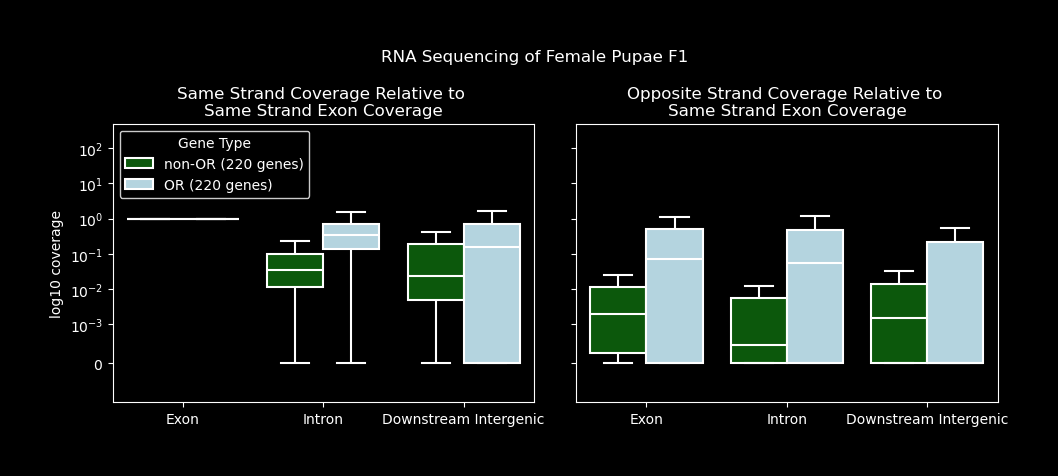

In [17]:
# Plot fwd_coverage_adult_intron_rel and rev_coverage_adult_intron_rel split by both_ORs

tissue = 'F1'

# Melt adjacent_gene_db for plotting
adjacent_gene_db_melted = adjacent_gene_db_subset.melt(
    id_vars=['both_ORs', 'nine-exon'],
    value_vars=[f'exon_same_rel_{tissue}', f'exon_opp_rel_{tissue}', f'intron_same_rel_{tissue}', f'intron_opp_rel_{tissue}', f'intergenic_same_rel_{tissue}', f'intergenic_opp_rel_{tissue}'],
    var_name='coverage_type',
    value_name='coverage'
) 

adjacent_gene_db_melted['same'] = adjacent_gene_db_melted['coverage_type'].str.contains('same')
adjacent_gene_db_melted['Type'] = adjacent_gene_db_melted['both_ORs'].apply(lambda x: "OR" if x==True else "non-OR")

# Remove NaN Rows using coverage column 
adjacent_gene_db_melted = adjacent_gene_db_melted[~adjacent_gene_db_melted['coverage'].isna()]

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

sns.boxplot(
    data=adjacent_gene_db_melted[adjacent_gene_db_melted['same']==True],
    x='coverage_type',
    y='coverage',
    hue='Type',
    ax=ax[0],
    palette=['darkgreen', 'lightblue'],
    linecolor='white', 
    linewidth=1.5, 
    fliersize=0, 
    hue_order=['non-OR', 'OR'],
    order = [f'exon_same_rel_{tissue}', f'intron_same_rel_{tissue}', f'intergenic_same_rel_{tissue}'],
)

sns.boxplot(
    data=adjacent_gene_db_melted[adjacent_gene_db_melted['same']==False],
    x='coverage_type',
    y='coverage',
    hue='Type',
    ax=ax[1],
    palette=['darkgreen', 'lightblue'], 
    linecolor='white', 
    linewidth=1.5, 
    fliersize=0, 
    hue_order=['non-OR', 'OR'],
    order = [f'exon_opp_rel_{tissue}', f'intron_opp_rel_{tissue}', f'intergenic_opp_rel_{tissue}'],
)

# Plotting 
for i in range(len(ax)): 
    ax[i].set_xticks(range(3))
    ax[i].set_xticklabels(['Exon', 'Intron', 'Downstream Intergenic'], rotation=0)
    ax[i].set_title(f'{"Same" if i==0 else "Opposite"} Strand Coverage Relative to \nSame Strand Exon Coverage')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('log10 coverage')
    ax[i].set_yscale('symlog', linthresh=1e-3)
    ax[i].set_ylim(-0.001, 500)

ax[0].set_ylabel('log10 coverage')
ax[1].get_legend().remove()
plt.suptitle(f'RNA Sequencing of Female Pupae {tissue.split("_")[0]}')

# Rename legend entries to include the number of genes
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, [f"{label} ({len(adjacent_gene_db_subset[adjacent_gene_db_subset['both_ORs'] == (label=="OR")])} genes)" for label in labels], title='Gene Type', loc='upper left')
plt.tight_layout()
plt.show()


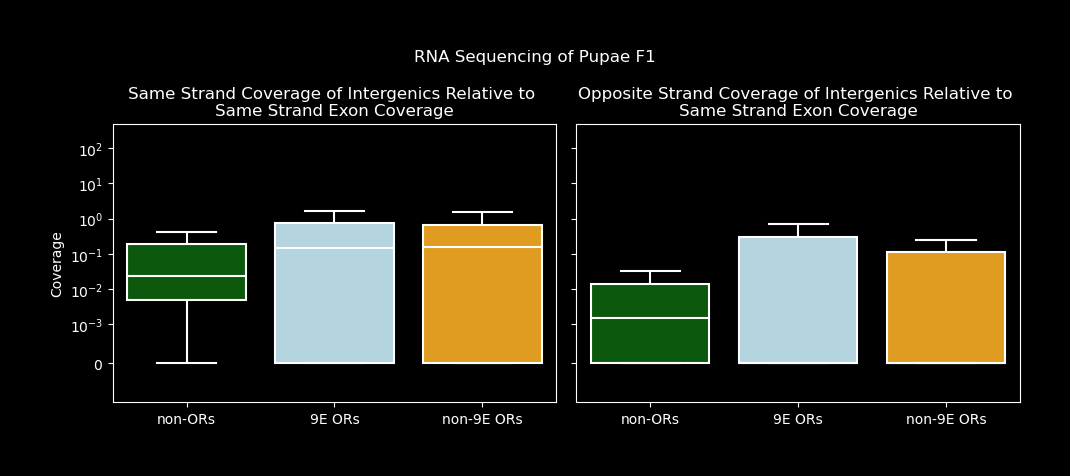

In [19]:
# Plot same_strand_coverage_adult_rel and opp_strand_coverage_adult_rel split by nine_exon 
tissue = 'F1'
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
sns.boxplot(
    x='nine-exon', 
    y=f'intergenic_same_rel_{tissue}', 
    data=adjacent_gene_db_subset, 
    ax=ax[0], 
    palette=['darkgreen', 'lightblue', 'orange'], 
    linecolor='white', 
    linewidth=1.5, 
    fliersize=0, 
    order=['non-OR', 'True', 'False'])
sns.boxplot(
    x='nine-exon', 
    y=f'intergenic_opp_rel_{tissue}', 
    data=adjacent_gene_db_subset, 
    ax=ax[1], 
    palette=['darkgreen', 'lightblue', 'orange'], 
    linecolor='white', 
    linewidth=1.5, 
    fliersize=0, 
    order=['non-OR', 'True', 'False'])
for i in range(len(ax)): 
    ax[i].set_title(f'{"Same" if i==0 else "Opposite"} Strand Coverage of Intergenics Relative to \nSame Strand Exon Coverage')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Coverage')
    ax[i].set_xticks([0, 1, 2])
    ax[i].set_xticklabels(['non-ORs', '9E ORs', 'non-9E ORs'])
    ax[i].set_yscale('symlog', linthresh=1e-3)
    ax[i].set_ylim(-0.001, 500)
    
plt.suptitle(f'RNA Sequencing of Pupae {tissue.split("_")[0]}')
plt.tight_layout()
plt.show()

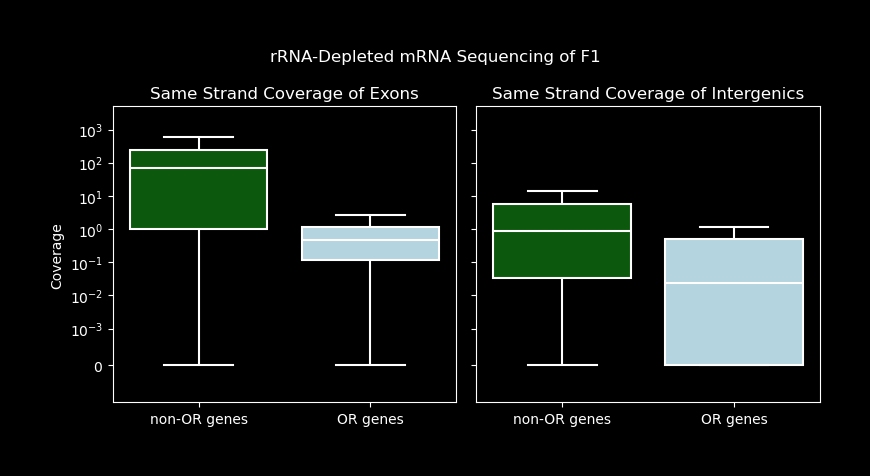

In [20]:
# Plot same_strand_coverage and opp_strand_coverage split by both_ORs
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True) 
plt.subplots_adjust(wspace=0.3, hspace=0.3)

sns.boxplot(
    x='both_ORs', 
    y=f'upstream_exon_same_{tissue}', 
    data=adjacent_gene_db_subset, 
    ax=ax[0], 
    palette=['darkgreen', 'lightblue'], 
    linecolor='white', 
    linewidth=1.5, 
    fliersize=0
)

sns.boxplot(
    x='both_ORs', 
    y=f'intergenic_same_{tissue}', 
    data=adjacent_gene_db_subset, 
    ax=ax[1], 
    palette=['darkgreen', 'lightblue'], 
    linecolor='white', 
    linewidth=1.5, 
    fliersize=0
)

for i in range(len(ax)): 
    ax[i].set_title(f'Same Strand Coverage of {"Exons" if i==0 else "Intergenics"}')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Coverage')
    ax[i].set_xticks([0, 1])
    ax[i].set_xticklabels(['non-OR genes', 'OR genes'])
    ax[i].set_yscale('symlog', linthresh=1e-3)
    ax[i].set_ylim(-0.001, 5000)

plt.suptitle(f'rRNA-Depleted mRNA Sequencing of {tissue.split("_")[0]}')
plt.tight_layout()
plt.show()

In [22]:
# Get the subset of adjacent_gene_db where the TA_size is greater than 2
adjacent_gene_db_subset_large_TAs = adjacent_gene_db_subset[adjacent_gene_db_subset['TA_size'] > 10]
adjacent_gene_db_subset_large_TAs = adjacent_gene_db_subset_large_TAs.sort_values(by='TA_size')
adjacent_gene_db_subset_large_TAs = adjacent_gene_db_subset_large_TAs.reset_index(drop=True)
adjacent_gene_db_subset_large_TAs['TA'] = adjacent_gene_db_subset_large_TAs['TA'].astype(int)
adjacent_gene_db_subset_large_TAs

,gene_1,gene_2,chromosome,start_1,end_1,start_2,end_2,strand_1,strand_2,distance,location,both_ORs,TA,TA_size,nine-exon,overlapping_feature,upstream_exon_fwd_F1,upstream_exon_rev_F1,upstream_intron_fwd_F1,upstream_intron_rev_F1,intergenic_fwd_F1,intergenic_rev_F1,intergenic_fwd_prop_F1,intergenic_rev_prop_F1,upstream_exon_same_F1,upstream_exon_opp_F1,upstream_intron_same_F1,upstream_intron_opp_F1,intergenic_same_F1,intergenic_opp_F1,exon_same_rel_F1,exon_opp_rel_F1,intron_same_rel_F1,intron_opp_rel_F1,intergenic_same_rel_F1,intergenic_opp_rel_F1
0,Or5-9E243,Or5-9E244,Chr10,1970779,1976706,1976854,1981310,-,-,148,Chr10:1976706-1976854,True,13,11.0,True,False,0.424419,1.806977,0.447794,0.309559,0.114865,0.000000,0.114865,0.000000,1.806977,0.424419,0.309559,0.447794,0.000000,0.114865,1.0,0.234878,0.171313,0.247814,0.000000,0.063567
1,Or5-9E244,Or5-9E245,Chr10,1976854,1981310,1984353,1988230,-,-,3043,Chr10:1981310-1984353,True,13,11.0,True,False,1.240248,3.149226,0.925200,0.476402,0.436411,0.832402,0.220177,0.353270,3.149226,1.240248,0.476402,0.925200,0.832402,0.436411,1.0,0.393826,0.151276,0.293787,0.264320,0.138577
2,Or5-9E245,Or5-9E246,Chr10,1984353,1988230,1990850,1994470,-,-,2620,Chr10:1988230-1990850,True,13,11.0,True,False,0.000000,0.193448,0.000000,0.000000,0.190840,0.380916,0.164504,0.216794,0.193448,0.000000,0.000000,0.000000,0.380916,0.190840,1.0,0.000000,0.000000,0.000000,1.969090,0.986518
3,Or5-9E246,Or5-9E247,Chr10,1990850,1994470,1995529,2001168,-,-,1059,Chr10:1994470-1995529,True,13,11.0,True,False,0.000000,0.386096,0.002932,0.135128,0.000000,0.000000,0.000000,0.000000,0.386096,0.000000,0.135128,0.002932,0.000000,0.000000,1.0,0.000000,0.349985,0.007593,0.000000,0.000000
4,Or5-9E247,Or5-9E248,Chr10,1995529,2001168,2003320,2007777,-,-,2152,Chr10:2001168-2003320,True,13,11.0,True,False,0.000000,0.571632,0.000000,0.198886,0.406599,0.779740,0.240242,0.389405,0.571632,0.000000,0.198886,0.000000,0.779740,0.406599,1.0,0.000000,0.347926,0.000000,1.364059,0.711294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Or5-9E317,Or5-9E318,Chr10,12998421,13003046,13003930,13006833,-,-,884,Chr10:13003046-13003930,True,17,82.0,True,False,1.410274,3.507672,0.358327,0.402307,0.932127,2.115385,0.346154,0.522624,3.507672,1.410274,0.402307,0.358327,2.115385,0.932127,1.0,0.402054,0.114693,0.102155,0.603074,0.265739
176,Or5-9E259,Or5-9E260,Chr10,12713650,12718768,12718944,12723816,+,+,176,Chr10:12718768-12718944,True,17,82.0,True,False,0.513400,0.245789,0.649799,0.142169,0.000000,0.000000,0.000000,0.000000,0.513400,0.245789,0.649799,0.142169,0.000000,0.000000,1.0,0.478747,1.265679,0.276916,0.000000,0.000000
177,Or5-9E258,Or5-9E259,Chr10,12708288,12713355,12713650,12718768,+,+,295,Chr10:12713355-12713650,True,17,82.0,True,False,0.397377,0.074754,0.222348,0.169314,0.322034,0.000000,0.322034,0.000000,0.397377,0.074754,0.222348,0.169314,0.322034,0.000000,1.0,0.188119,0.559540,0.426078,0.810399,0.000000
178,Or5-9E256,Or5-9E257,Chr10,12699808,12703708,12703802,12707659,+,+,94,Chr10:12703708-12703802,True,17,82.0,True,False,1.772158,0.338854,0.000000,0.411515,0.000000,0.000000,0.000000,0.000000,1.772158,0.338854,0.000000,0.411515,0.000000,0.000000,1.0,0.191210,0.000000,0.232211,0.000000,0.000000


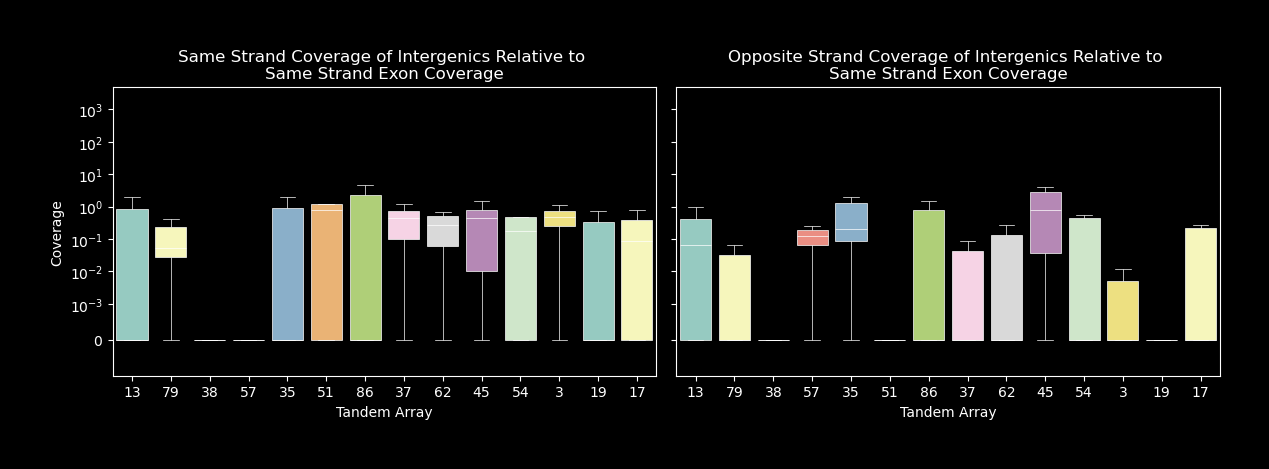

In [23]:
# Plot same_strand_coverage and opp_strand_coverage split by TA 
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.boxplot(
    x='TA', 
    y=f'intergenic_same_rel_{tissue}', 
    data=adjacent_gene_db_subset_large_TAs, 
    ax=ax[0], 
    order=adjacent_gene_db_subset_large_TAs['TA'].unique(), 
    palette='Set3',
    linecolor='white', 
    linewidth=0.5, 
    fliersize=0,
)
    
sns.boxplot(
    x='TA', 
    y=f'intergenic_opp_rel_{tissue}', 
    data=adjacent_gene_db_subset_large_TAs, 
    ax=ax[1], 
    order=adjacent_gene_db_subset_large_TAs['TA'].unique(), 
    palette='Set3',
    linecolor='white', 
    linewidth=0.5, 
    fliersize=0,
)
for i in range(len(ax)): 
    ax[i].set_title(f'{"Same" if i==0 else "Opposite"} Strand Coverage of Intergenics Relative to \nSame Strand Exon Coverage')
    ax[i].set_xlabel('Tandem Array')
    ax[i].set_ylabel('Coverage')
    ax[i].set_yscale('symlog', linthresh=1e-3)
    ax[i].set_ylim(-0.001, 5000)

plt.tight_layout()
plt.show()

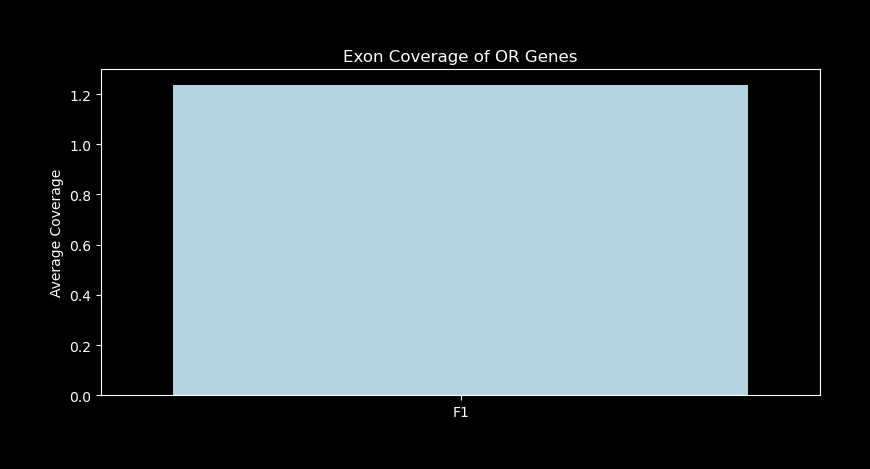

In [25]:
# Plot same strand exon coverage of ORs for all tissues 
tissues = ['F1']

# melt adjacent_gene_db_subset for plotting
adjacent_gene_db_melted = adjacent_gene_db_subset.melt(
    id_vars=['both_ORs', 'nine-exon'],
    value_vars=[f'upstream_exon_same_{tissue}' for tissue in tissues],
    var_name='tissue',
    value_name='coverage'
)

adjacent_gene_db_melted['Type'] = adjacent_gene_db_melted['both_ORs'].apply(lambda x: "OR" if x==True else "non-OR")
adjacent_gene_db_melted['tissue_name'] = adjacent_gene_db_melted['tissue'].apply(lambda x: x.split('upstream_exon_same_')[1].split('_')[0])

# Plot boxplot of coverage, split by tissue and color by Type 
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.barplot(
    x='tissue_name', 
    y='coverage', 
    data=adjacent_gene_db_melted[adjacent_gene_db_melted['Type'] == 'OR'], 
    estimator=np.mean,
    palette=['lightblue'], 
    ci=None  # Disable confidence intervals if not needed
)

plt.title('Exon Coverage of OR Genes')
plt.xlabel('')
plt.ylabel('Average Coverage')
plt.tight_layout()
plt.show()

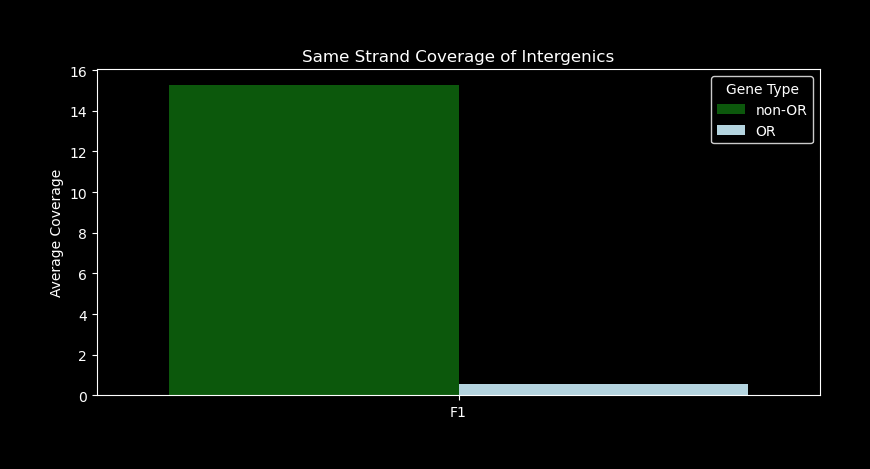

In [26]:
# Plot same strand exon coverage of ORs for all tissues 
tissues = ['F1']

# melt adjacent_gene_db_subset for plotting
adjacent_gene_db_melted = adjacent_gene_db_subset.melt(
    id_vars=['both_ORs', 'nine-exon'],
    value_vars=[f'intergenic_same_{tissue}' for tissue in tissues],
    var_name='tissue',
    value_name='coverage'
)

adjacent_gene_db_melted['Type'] = adjacent_gene_db_melted['both_ORs'].apply(lambda x: "OR" if x==True else "non-OR")
adjacent_gene_db_melted['tissue_name'] = adjacent_gene_db_melted['tissue'].apply(lambda x: x.split('intergenic_same_')[1].split('_')[0])

# Plot boxplot of coverage, split by tissue and color by Type 
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.barplot(
    x='tissue_name', 
    y='coverage', 
    data=adjacent_gene_db_melted, 
    hue='Type', 
    estimator=np.mean,
    palette=['darkgreen', 'lightblue'], 
    hue_order=['non-OR', 'OR'], 
    ci=None  # Disable confidence intervals if not needed
)

plt.title('Same Strand Coverage of Intergenics')
plt.xlabel('')
plt.ylabel('Average Coverage')
plt.legend(title='Gene Type', loc='upper right')
plt.tight_layout()
plt.show()

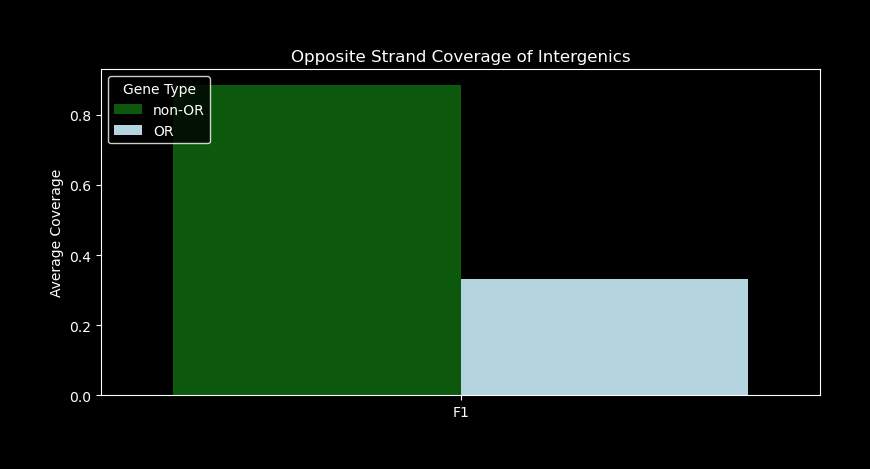

In [27]:
# Plot same strand exon coverage of ORs for all tissues 
tissues = ['F1']

# melt adjacent_gene_db_subset for plotting
adjacent_gene_db_melted = adjacent_gene_db_subset.melt(
    id_vars=['both_ORs', 'nine-exon'],
    value_vars=[f'intergenic_opp_{tissue}' for tissue in tissues],
    var_name='tissue',
    value_name='coverage'
)

adjacent_gene_db_melted['Type'] = adjacent_gene_db_melted['both_ORs'].apply(lambda x: "OR" if x==True else "non-OR")
adjacent_gene_db_melted['tissue_name'] = adjacent_gene_db_melted['tissue'].apply(lambda x: x.split('intergenic_opp_')[1].split('_')[0])

# Plot boxplot of coverage, split by tissue and color by Type 
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.barplot(
    x='tissue_name', 
    y='coverage', 
    data=adjacent_gene_db_melted, 
    hue='Type', 
    estimator=np.mean,
    palette=['darkgreen', 'lightblue'], 
    hue_order=['non-OR', 'OR'], 
    ci=None  # Disable confidence intervals if not needed
)

plt.title('Opposite Strand Coverage of Intergenics')
plt.xlabel('')
plt.ylabel('Average Coverage')
plt.legend(title='Gene Type', loc='upper left')
plt.tight_layout()
plt.show()